<a href="https://colab.research.google.com/github/DuckFarren/busbot-dialogflow-telegram/blob/master/3DCNN%2B3LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
cd /content/drive/My Drive/Colab Notebooks/letsbox

/content/drive/My Drive/Colab Notebooks/letsbox


In [0]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten, Reshape
from keras.layers.convolutional import Conv3D, MaxPooling3D,Conv2D,AveragePooling2D,AveragePooling3D
from keras.layers import Dense, GlobalAveragePooling3D,GlobalAveragePooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler,ReduceLROnPlateau
from keras.optimizers import SGD, RMSprop, Adadelta
from keras.utils import np_utils, generic_utils
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional_recurrent import ConvLSTM2D

# import theano
import os
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn import preprocessing


Using TensorFlow backend.


In [0]:
pip install git+https://github.com/okankop/vidaug

  Cloning https://github.com/okankop/vidaug to /tmp/pip-req-build-l0cyrm_q
  Running command git clone -q https://github.com/okankop/vidaug /tmp/pip-req-build-l0cyrm_q
  Created wheel for vidaug: filename=vidaug-0.1-cp36-none-any.whl size=13005 sha256=5f4fb5200f438ac08ee72217791b6a56071f8d1b9d2e9ac5434e5a87c066c268
  Stored in directory: /tmp/pip-ephem-wheel-cache-4iq2myi4/wheels/3f/87/a3/14ed7eb5a878e2e239961990c700a400836e369fc109ecad86
Successfully built vidaug


In [0]:
from vidaug import augmentors as va

In [0]:
def vid_loader(path,showimg=False):
    frames = []
    cap = cv2.VideoCapture(path)
    fps = cap.get(cv2.CAP_PROP_FPS) 
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
#     print('number of frames = ' + str(frame_count))

    for k in range(int(frame_count)):
        ret, frame = cap.read()
        frame=cv2.resize(frame,(128,128),interpolation=cv2.INTER_AREA)
        rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        if showimg:
            plt.imshow(gray)
            plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
            plt.show()
        frames.append(rgb)
    return np.array(frames)

def crop_vid(np_vid,framecnt):
    crop = va.TemporalCenterCrop(framecnt)
    return crop(np_vid)

def map_funcs(obj, func_list):
    return [func(obj) for func in func_list]


hflip = va.HorizontalFlip()
inv_color = va.InvertColor()
# add = va.Add(-100)
# affine = va.PiecewiseAffineTransform(5,21,5)
blur = va.GaussianBlur(1)
translate = va.RandomTranslate(20,20)
# shear = va.RandomShear(0.2,0.2)
salt = va.Salt(30)
# pepper = va.Pepper(30)

# aug_func = [hflip,inv_color,add,affine,blur,translate,shear,salt,pepper]
aug_func = [hflip,inv_color,blur,translate,salt]

In [0]:
X_tr = []
label = []
img_rows,img_cols,img_depth=128,128,24

ds_path = 'datasets'
folders = ['jap','hook','uppercut','none']
class_num = 0

for sub in folders:
    
    ls_path = os.path.join(ds_path,sub)
    listing = sorted(os.listdir(ls_path))
    
    for vid in listing:
        all_from_one = []
        vid_ls_path = os.path.join(ls_path,vid)
        vid_np = vid_loader(vid_ls_path)
        print(vid_ls_path+' loaded to np array')
        
        # first crop to 48 frames
        vid_48 = crop_vid(vid_np,48)

        # split 3 ways
        center_frames = crop_vid(vid_48,img_depth)
        # perform 6 augmentation to even_frames => length:6 x 24frame
        all_from_one.append([center_frames])
        all_from_one.append(map_funcs(center_frames,aug_func))
        
        even_frames = vid_48[::2] 
        all_from_one.append([even_frames])
        all_from_one.append(map_funcs(even_frames,aug_func))
        
        odd_frames = vid_48[1::2]
        all_from_one.append([odd_frames])
        all_from_one.append(map_funcs(odd_frames,aug_func))
        
        for aug_vids in all_from_one:
            for aug in aug_vids:
                input_img = np.array(aug)
                ipt=np.rollaxis(np.rollaxis(input_img,2,0),2,0)
                ipt=np.rollaxis(ipt,2,0)
                X_tr.append(ipt)
                label.append(class_num)
        
    class_num+=1

X_tr_array = np.array(X_tr)   # convert the frames read into array
#     # print (ipt.shape)
num_samples = len(X_tr) 
print (num_samples)

In [0]:
label=np.asarray(label,dtype = int)

In [0]:
train_data = [X_tr_array,label]

(X_train, y_train) = (train_data[0],train_data[1])
print('X_Train shape:', X_train.shape)

# train_set = np.zeros((num_samples, img_depth, img_cols,img_rows,3))

# for h in range(num_samples):
#     train_set[h][:][:][:][:]=X_train[h,:,:,:]
  
patch_size = 24    # img_depth or number of frames used for each video

# print(train_set.shape, 'train samples')


X_Train shape: (3672, 24, 128, 128, 3)


In [0]:
# CNN Training parameters
nb_classes = 4

In [0]:
# convert class vectors to binary class matrices
Y_train = np_utils.to_categorical(y_train, nb_classes)

In [0]:
# Pre-processing

train_set = X_train.astype('float16')
print(np.mean(train_set))
train_set -= np.mean(train_set)
print(np.max(train_set))
train_set /=np.max(train_set)

111.6
143.4


In [0]:
X_train_new, X_val_new, y_train_new,y_val_new = train_test_split(train_set, Y_train, test_size=0.2, random_state=20, stratify=Y_train)

In [0]:
# Define model
weight_decay = 0.00005
import tensorflow as tf
keras=tf.contrib.keras
l2=keras.regularizers.l2

model = Sequential()
model.add(Conv3D(16,(3,3,3),
                        input_shape=(patch_size, img_cols, img_rows, 3),
                        activation='relu'))
model.add(Conv3D(16,(3,3,3), strides=(1,1,1),padding='same', 
                    dilation_rate=(1,1,1), kernel_initializer='he_normal',
                    kernel_regularizer=l2(weight_decay), use_bias=False, 
                    name='Conv3D_2a_a', activation = 'relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))


model.add(Conv3D(32,(3,3,3), strides=(1,1,1),padding='same', 
                    dilation_rate=(1,1,1), kernel_initializer='he_normal',
                    kernel_regularizer=l2(weight_decay), use_bias=False, 
                    name='Conv3D_2b_a', activation = 'relu'))
model.add(Conv3D(32,(3,3,3), strides=(1,1,1),padding='same', 
                    dilation_rate=(1,1,1), kernel_initializer='he_normal',
                    kernel_regularizer=l2(weight_decay), use_bias=False, 
                    name='Conv3D_2b_b', activation = 'relu'))
model.add(MaxPooling3D(pool_size=(1, 2,2)))


model.add(Conv3D(64,(3,3,3), strides=(1,1,1),padding='same', 
                    dilation_rate=(1,1,1), kernel_initializer='he_normal',
                    kernel_regularizer=l2(weight_decay), use_bias=False, 
                    name='Conv3D_2c_a', activation = 'relu'))
model.add(Conv3D(64,(3,3,3), strides=(1,1,1),padding='same', 
                    dilation_rate=(1,1,1), kernel_initializer='he_normal',
                    kernel_regularizer=l2(weight_decay), use_bias=False, 
                    name='Conv3D_2c_b', activation = 'relu'))
model.add(Conv3D(64,(3,3,3), strides=(1,1,1),padding='same', 
                    dilation_rate=(1,1,1), kernel_initializer='he_normal',
                    kernel_regularizer=l2(weight_decay), use_bias=False, 
                    name='Conv3D_2c_c', activation = 'relu'))
model.add(MaxPooling3D(pool_size=(1, 2,2)))


model.add(Conv3D(128,(3,3,3), strides=(1,1,1),padding='same', 
                    dilation_rate=(1,1,1), kernel_initializer='he_normal',
                    kernel_regularizer=l2(weight_decay), use_bias=False, 
                    name='Conv3D_2d_a', activation = 'relu'))
model.add(Conv3D(128,(3,3,3), strides=(1,1,1),padding='same', 
                    dilation_rate=(1,1,1), kernel_initializer='he_normal',
                    kernel_regularizer=l2(weight_decay), use_bias=False, 
                    name='Conv3D_2d_b', activation = 'relu'))
model.add(Conv3D(128,(3,3,3), strides=(1,1,1),padding='same', 
                    dilation_rate=(1,1,1), kernel_initializer='he_normal',
                    kernel_regularizer=l2(weight_decay), use_bias=False, 
                    name='Conv3D_2d_c', activation = 'relu'))
model.add(MaxPooling3D(pool_size=(1, 2, 2)))






model.add(ConvLSTM2D(filters=64, kernel_size=(3,3),
                  strides=(1,1),padding='same',
                      kernel_initializer='he_normal', recurrent_initializer='he_normal',
                      kernel_regularizer=l2(weight_decay), recurrent_regularizer=l2(weight_decay),
                      return_sequences=True, name='gatedclstm2d_2'))

model.add(ConvLSTM2D(filters=64, kernel_size=(3,3),
                  strides=(1,1),padding='same',
                      kernel_initializer='he_normal', recurrent_initializer='he_normal',
                      kernel_regularizer=l2(weight_decay), recurrent_regularizer=l2(weight_decay),
                      return_sequences=True, name='gatedclstm2d_3'))

model.add(ConvLSTM2D(filters=64, kernel_size=(3,3),
                  strides=(1,1),padding='same',
                      kernel_initializer='he_normal', recurrent_initializer='he_normal',
                      kernel_regularizer=l2(weight_decay), recurrent_regularizer=l2(weight_decay),
                      return_sequences=True, name='gatedclstm2d_4'))


#model.add(MaxPooling3D(pool_size=(nb_pool[0], nb_pool[0], nb_pool[0])))
#model.add(Flatten())
model.add(GlobalAveragePooling3D())
model.add(Dropout(0.5))
model.add(Dense(nb_classes,kernel_initializer='normal'))

model.add(Activation('softmax'))

In [0]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 22, 126, 126, 16)  1312      
_________________________________________________________________
Conv3D_2a_a (Conv3D)         (None, 22, 126, 126, 16)  6912      
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 11, 63, 63, 16)    0         
_________________________________________________________________
Conv3D_2b_a (Conv3D)         (None, 11, 63, 63, 32)    13824     
_________________________________________________________________
Conv3D_2b_b (Conv3D)         (None, 11, 63, 63, 32)    27648     
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 11, 31, 31, 32)    0         
_________________________________________________________________
Conv3D_2c_a (Conv3D)         (None, 11, 31, 31, 64)   

In [0]:
# import os
save_dir = os.path.join(os.getcwd(),'saved_model')
# print(os.getcwd())

model_name = "3DCNN+3LSTM_128_4_aug_v4.h5"
# if not os.path.isdir(save_dir):
#     os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
checkpoint = ModelCheckpoint(model_path, monitor = 'val_acc', 
                            save_best_only=True, verbose=1)
#earlystop
earlystop = EarlyStopping(monitor='val_loss', patience=50, verbose =1)

In [0]:
sgd = SGD(lr=0.005,  momentum=0.9, nesterov=False)
# rms = RMSprop(decay=1e-6)
# ada = Adadelta(lr=0.1,decay=1e-6)
model.compile(loss='categorical_crossentropy', 
              optimizer=sgd,
              #optimizer=ada,
              #optimizer = Adam(lr=0.0001),
              metrics=['acc'])
# Split the data


In [0]:
batch_size = 50
nb_epoch = 50
#steps_per_epoch=int((len(X_val_new)*1.5)/batch_size)
lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.05, 
                               cooldown=0, patience=10, min_lr=0.005/(2^4),verbose=1)
hist = model.fit(
    X_train_new,
    y_train_new,
    validation_data=(X_val_new,y_val_new),
    batch_size=batch_size,
    epochs = nb_epoch,
    shuffle=True,
    callbacks=[checkpoint,lr_reducer]
    )

Train on 2937 samples, validate on 735 samples
Epoch 1/50
2937/2937 [==============================] - 322s 110ms/step - loss: 1.6074 - acc: 0.2438 - val_loss: 1.6049 - val_acc: 0.2367

Epoch 00001: val_acc improved from -inf to 0.23673, saving model to /content/drive/My Drive/Colab Notebooks/letsbox/saved_model/3DCNN+3LSTM_128_4_aug_v4.h5
Epoch 2/50
2937/2937 [==============================] - 307s 104ms/step - loss: 1.6060 - acc: 0.2571 - val_loss: 1.6047 - val_acc: 0.2517

Epoch 00002: val_acc improved from 0.23673 to 0.25170, saving model to /content/drive/My Drive/Colab Notebooks/letsbox/saved_model/3DCNN+3LSTM_128_4_aug_v4.h5
Epoch 3/50
2937/2937 [==============================] - 308s 105ms/step - loss: 1.6052 - acc: 0.2618 - val_loss: 1.6043 - val_acc: 0.2544

Epoch 00003: val_acc improved from 0.25170 to 0.25442, saving model to /content/drive/My Drive/Colab Notebooks/letsbox/saved_model/3DCNN+3LSTM_128_4_aug_v4.h5
Epoch 4/50
2937/2937 [==============================] - 307s 1

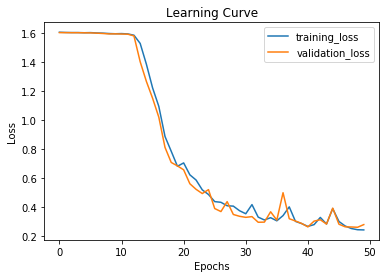

In [0]:
training_loss = hist.history['loss']
val_loss = hist.history['val_loss']

plt.plot(training_loss, label="training_loss")
plt.plot(val_loss, label="validation_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Learning Curve")
plt.legend(loc='best')
plt.show()

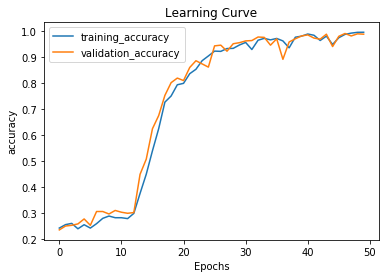

In [0]:
training_acc = hist.history['acc']
val_acc = hist.history['val_acc']

plt.plot(training_acc, label="training_accuracy")
plt.plot(val_acc, label="validation_accuracy")
plt.xlabel("Epochs")
plt.ylabel("accuracy")
plt.title("Learning Curve")
plt.legend(loc='best')
plt.show()

In [0]:
from keras import backend as K
# This line must be executed before loading Keras model.
K.set_learning_phase(0)

from keras.models import load_model
model = load_model('./saved_model/3DCNN+3LSTM_128_4.h5')

In [0]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 22, 126, 126, 16)  1312      
_________________________________________________________________
Conv3D_2a_a (Conv3D)         (None, 22, 126, 126, 16)  6912      
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 11, 63, 63, 16)    0         
_________________________________________________________________
Conv3D_2b_a (Conv3D)         (None, 11, 63, 63, 32)    13824     
_________________________________________________________________
Conv3D_2b_b (Conv3D)         (None, 11, 63, 63, 32)    27648     
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 11, 31, 31, 32)    0         
_________________________________________________________________
Conv3D_2c_a (Conv3D)         (None, 11, 31, 31, 64)   

In [0]:
print(model.outputs)
print(model.inputs)

[<tf.Tensor 'activation_1_2/Softmax:0' shape=(?, 4) dtype=float32>]
[<tf.Tensor 'conv3d_1_input_2:0' shape=(?, 24, 128, 128, 3) dtype=float32>]
